In [9]:
%matplotlib inline
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, ImageColorGenerator


In [2]:
train = pd.read_csv('cleaned_hm.csv')

In [5]:
train[:20]

,hmid,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category
0,27673,2053,24h,I went on a successful date with someone I fel...,I went on a successful date with someone I fel...,True,1,NaN,affection
1,27674,2,24h,I was happy when my son got 90% marks in his e...,I was happy when my son got 90% marks in his e...,True,1,NaN,affection
2,27675,1936,24h,I went to the gym this morning and did yoga.,I went to the gym this morning and did yoga.,True,1,NaN,exercise
3,27676,206,24h,We had a serious talk with some friends of our...,We had a serious talk with some friends of our...,True,2,bonding,bonding
4,27677,6227,24h,I went with grandchildren to butterfly display...,I went with grandchildren to butterfly display...,True,1,NaN,affection
5,27678,45,24h,I meditated last night.,I meditated last night.,True,1,leisure,leisure
6,27679,195,24h,"I made a new recipe for peasant bread, and it ...","I made a new recipe for peasant bread, and it ...",True,1,NaN,achievement
7,27680,740,24h,I got gift from my elder brother which was rea...,I got gift from my elder brother which was rea...,True,1,NaN,affection
8,27681,3,24h,YESTERDAY MY MOMS BIRTHDAY SO I ENJOYED,YESTERDAY MY MOMS BIRTHDAY SO I ENJOYED,True,1,NaN,enjoy_the_moment
9,27682,4833,24h,Watching cupcake wars with my three teen children,Watching cupcake wars with my three teen children,True,1,NaN,affection


In [13]:
demo = pd.read_csv('demographic.csv')
demo[:20]

,wid,age,country,gender,marital,parenthood
0,1,37.0,USA,m,married,y
1,2,29.0,IND,m,married,y
2,3,25,IND,m,single,n
3,4,32,USA,m,married,y
4,5,29,USA,m,married,y
5,6,35,IND,m,married,y
6,7,34,USA,m,married,y
7,8,29,VNM,m,single,n
8,9,61,USA,f,married,y
9,10,27,USA,m,single,n


In [10]:
df_train = train[train['cleaned_hm'].notnull()]
len_count = df_train['cleaned_hm'].apply(lambda x: len(x.split()))
len_count.describe()

count    100535.000000
mean         18.298503
std          21.474146
min           2.000000
25%           9.000000
50%          14.000000
75%          21.000000
max        1179.000000
Name: cleaned_hm, dtype: float64

(-0.5, 3599.5, 2699.5, -0.5)

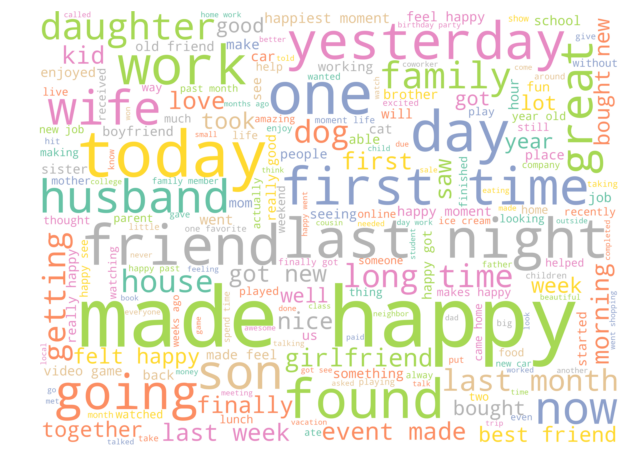

In [11]:
text = ' '.join(df_train['cleaned_hm'].tolist())
text = text.lower()
wordcloud = WordCloud(background_color="white", height=2700, width=3600).generate(text)
plt.figure( figsize=(14,8) )
plt.imshow(wordcloud.recolor(colormap=plt.get_cmap('Set2')), interpolation='bilinear')
plt.axis("off")

(-0.5, 3599.5, 2699.5, -0.5)

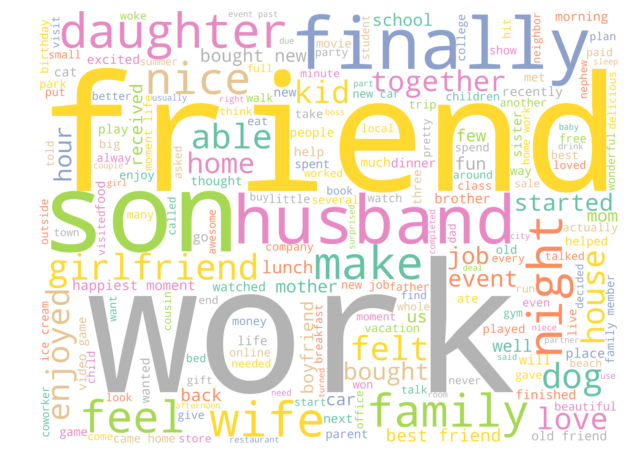

In [12]:
LIMIT_WORDS = ['happy', 'day', 'got', 'went', 'today', 'made', 'one', 'two', 'time', 'last', 'first', 'going', 'getting', 'took', 'found', 'lot', 'really', 'saw', 'see', 'month', 'week', 'day', 'yesterday', 'year', 'ago', 'now', 'still', 'since', 'something', 'great', 'good', 'long', 'thing', 'toi', 'without', 'yesteri', '2s', 'toand', 'ing']

text = ' '.join(df_train['cleaned_hm'].tolist())
text = text.lower()
for w in LIMIT_WORDS:
    text = text.replace(' ' + w, '')
    text = text.replace(w + ' ', '')
wordcloud = WordCloud(background_color="white", height=2700, width=3600).generate(text)
plt.figure( figsize=(14,8) )
plt.imshow(wordcloud.recolor(colormap=plt.get_cmap('Set2')), interpolation='bilinear')
plt.axis("off")

In [19]:
merge_data = pd.merge(train, demo, on='wid')
gender_data = merge_data[['cleaned_hm', 'gender']]
gender_data[gender_data['gender'] == "f"][:20]

,cleaned_hm,gender
93,I went to the gym this morning and did yoga.,f
94,My husband passed his DOT physical and I don't...,f
95,I went to bible study tonight with special nee...,f
96,I lost 5 pounds which is awesome considering I...,f
97,My husband started working more after having h...,f
98,My baby started sleeping through the night aft...,f
99,My husband went with me to the park today. He ...,f
100,My son went to a birthday party with a friend ...,f
101,I went to church tonight and heard an amazing ...,f
102,My son got all As and Bs on his report card. H...,f


In [20]:
gender_data[gender_data['gender'] == "m"][:20]

,cleaned_hm,gender
0,I went on a successful date with someone I fel...,m
1,I played a new game that was fun and got to en...,m
2,I listened to some music and heard an entire a...,m
3,Went to see a movie with my friend,m
4,"Played guitar, learning a song on it",m
5,Talked to my romantic prospect,m
6,I played a game for about half an hour.,m
7,I discovered another album I hadn't heard by a...,m
8,I talked to the girl I'm dating about some int...,m
9,I was happy when my son got 90% marks in his e...,m


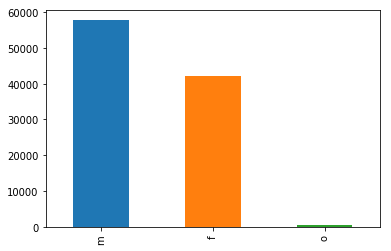

In [21]:
gender_data.gender.value_counts().plot(kind='bar')

In [22]:
gender_bin_data = gender_data[(gender_data['gender'] == 'm') | (gender_data['gender'] == 'f')]

print("Happy moments written by male/female: {}".format(gender_bin_data['cleaned_hm'].size))

Happy moments written by male/female: 99759


In [23]:
gender_bin_data = gender_bin_data.assign(gender_bin=(np.where(gender_bin_data['gender']=='m', 1, 0)))

gender_bin_data.head()

,cleaned_hm,gender,gender_bin
0,I went on a successful date with someone I fel...,m,1
1,I played a new game that was fun and got to en...,m,1
2,I listened to some music and heard an entire a...,m,1
3,Went to see a movie with my friend,m,1
4,"Played guitar, learning a song on it",m,1


In [24]:
hm_size = gender_bin_data['cleaned_hm'].size
num_train_hm = int(0.7 * gender_bin_data['cleaned_hm'].size)

train_hm = gender_bin_data.iloc[0:num_train_hm]
test_hm = gender_bin_data.iloc[num_train_hm:hm_size]
test_hm = test_hm.reset_index(drop=True)

test_hm.head()


,cleaned_hm,gender,gender_bin
0,"I started to walk more around the office, meet...",f,0
1,I bought my mom a bonsai tree for Mother's Day...,f,0
2,I was able to plan out the next two months as ...,f,0
3,I had dinner with coworkers who were leaving e...,f,0
4,I bought presents for my nieces for their home...,f,0


In [25]:
def clean_up_texts(hm_data):
    prepro_hm = []
    stops = set(stopwords.words("english"))
    for i in range(0, hm_data['cleaned_hm'].size):
        # Remove non-english words, including punctuations and numbers
        letters = re.sub("[^a-zA-Z]", " ", hm_data.iloc[i]['cleaned_hm'])

        # Convert all words to lower case
        lower_words = letters.lower()

        # Tokenize the sentences
        tokens = lower_words.split()

        # Reconstruct the processed tokens into a string
        prepro_string = " ".join(tokens)

        prepro_hm.append(prepro_string)
        
    return prepro_hm
    
prepro_train = clean_up_texts(train_hm)
prepro_test = clean_up_texts(test_hm)
print("Texts cleaned up! \n")

Texts cleaned up! 



In [26]:
prepro_train[:10]

['i went on a successful date with someone i felt sympathy and connection with',
 'i played a new game that was fun and got to enjoy the mechanics of it',
 'i listened to some music and heard an entire album i hadn t heard more than once before',
 'went to see a movie with my friend',
 'played guitar learning a song on it',
 'talked to my romantic prospect',
 'i played a game for about half an hour',
 'i discovered another album i hadn t heard by a band i recently got into',
 'i talked to the girl i m dating about some interesting topics',
 'i was happy when my son got marks in his examination']

In [27]:
vectorizer = CountVectorizer()
features_train_hm = vectorizer.fit_transform(prepro_train)
train_array_hm = features_train_hm.toarray()

print("Dimension of the training data: {}".format(train_array_hm.shape))

Dimension of the training data: (69831, 20737)


In [28]:
vocab = vectorizer.get_feature_names()

vocab[:20]

['aa',
 'aaa',
 'aadat',
 'aadhaar',
 'aadhar',
 'aagra',
 'aakshayatriya',
 'aas',
 'aashwin',
 'ab',
 'aback',
 'abacus',
 'abandon',
 'abandoned',
 'abasket',
 'abating',
 'abbott',
 'abby',
 'abc',
 'abcs']

In [29]:
from sklearn.linear_model import LogisticRegression

logi_model = LogisticRegression()
logi_model.fit(train_array_hm, train_hm['gender_bin'])

logi_model.score(train_array_hm, train_hm['gender_bin'])

/Users/lumin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.7602640661024473

In [30]:
feature_names = vocab
coefficients = logi_model.coef_.tolist()[0]
weight_df = pd.DataFrame({'Word': feature_names,
                          'Coeff': coefficients})
weight_df = weight_df.sort_values(['Coeff', 'Word'], ascending=[0, 1])
weight_df.head(n=10)


,Word,Coeff
20291,wife,3.178936
7642,girlfriend,2.850135
7593,gf,2.000954
17551,stone,1.917786
16855,smoking,1.832677
14631,reaches,1.776467
16091,seattle,1.755496
1661,begging,1.747624
3441,climbs,1.674528
20172,wend,1.660410


In [31]:
weight_df.tail(n=10)

,Word,Coeff
7857,grandkids,-1.957565
11991,nails,-1.979667
8774,hubby,-2.092478
1292,babysit,-2.099736
1953,blissful,-2.118809
10043,knitting,-2.153761
10932,makeup,-2.278418
11846,mth,-2.541336
2195,boyfriend,-2.633442
8842,husband,-3.364641


In [32]:
features_test_hm = vectorizer.transform(prepro_test)
test_array_hm = features_test_hm.toarray()

print("Dimension of the test data: {}".format(test_array_hm.shape))

Dimension of the test data: (29928, 20737)


In [33]:
predictions = logi_model.predict(test_array_hm)

In [34]:
from sklearn import metrics

print(metrics.accuracy_score(test_hm['gender_bin'], predictions))

0.6395682972467255
